In [1]:
nevecs = 60
ncomps = 500
nbasecomps = 20
crop_size=180
ncauses = 2
dr_method = 'PCA'

In [2]:
from pathlib import Path
import os, sys

In [3]:

macaw_path = Path(os.getcwd())
sys.path.append(str(macaw_path) +'/')

exp_name = 'no_bias'

train_csv_path = macaw_path/'splits'/'train.csv'
train_img_path = macaw_path/'no_bias'/'train'

# test_csv_path = macaw_path/'data'/'ukbb'/'test_hc.csv'
# test_img_path = macaw_path/'data'/'ukbb'/'axial'/'test_hc'
# 
pca_path = macaw_path/exp_name/f'train_hc_pca_{ncomps}.pkl'
# 
train_path = macaw_path/exp_name/f'train_hc_data_PCA_{ncomps}.pkl'
# test_path = macaw_path/'data'/'ukbb'/'axial'/f'test_hc_data_PCA_{ncomps}.pkl'
model_base_path = macaw_path/'models'/exp_name/f'{dr_method}_{ncomps}'/f'{nevecs}'

if not os.path.exists(model_base_path):
    os.makedirs(model_base_path)

In [4]:
import pickle

with open(train_path, 'rb') as f:
    train = pickle.load(f)
    
disease = train['disease']
bias = train['bias']

encoded_data = train['encoded_data']
pca = train['pca']

In [5]:
encoded_data.shape

(1005, 500)

In [6]:
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import numpy as np

[Text(0.5, 1.0, 'disease')]

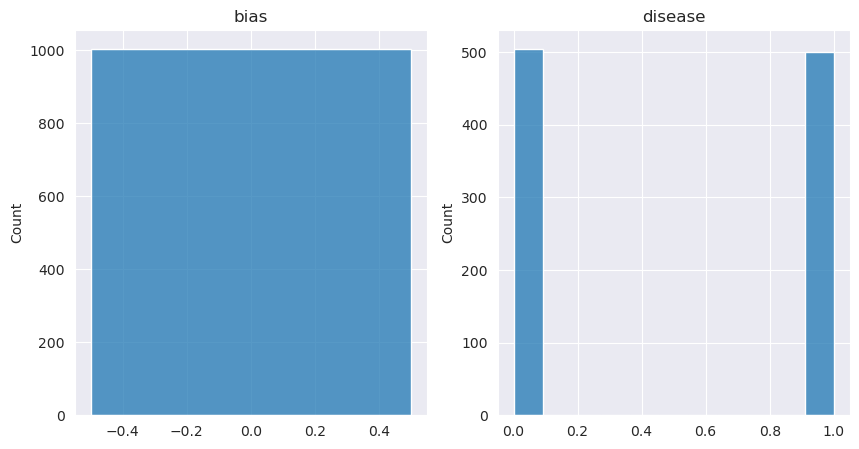

In [7]:
import seaborn as sns

sb = 2
fig, axs = plt.subplots(1,sb, figsize=(sb*5,5))

sns.histplot(bias,ax=axs[0],fill=True)
axs[0].set(title = "bias")
sns.histplot(disease,ax=axs[1], fill=True)
axs[1].set(title="disease")
# sns.histplot(encoded_data[0],ax=axs[3], fill=True)
# axs[3].set(title="PCA0")

## Causal Graph

In [8]:
disease_to_latents = [(0,i) for i in range(ncauses,nevecs+ncauses)]

bias_to_latents = [(1,i) for i in range(ncauses,nevecs+ncauses)]

autoregressive_latents = [(i,j) for i in range(ncauses,nevecs+ncauses) for j in range(i+1,nevecs+ncauses)]
# autoregressive_latents = [(i,j) for i in range(ncauses,2*ncauses) for j in range(i+1,nevecs+ncauses)]
# autoregressive_latents = []
edges = disease_to_latents + bias_to_latents + autoregressive_latents

## Priors

In [9]:
P_bias = np.sum(bias)/len(bias)
print(P_bias)

P_dis = np.sum(disease)/len(disease)
print(P_dis)

0.0
0.4975124378109453


In [10]:
import torch
import yaml
from utils.helpers import dict2namespace

with open(macaw_path/'config'/'ukbb.yaml', 'r') as f:
    config_raw = yaml.load(f, Loader=yaml.FullLoader)
    
config = dict2namespace(config_raw)
config.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [11]:
torch.cuda.is_available()

True

In [12]:
config.device

device(type='cuda')

In [13]:
import torch.distributions as td

priors = [(slice(0,1),td.Bernoulli(torch.tensor([P_bias]).to(torch.device(config.device)))), # bias
          (slice(1,2),td.Bernoulli(torch.tensor([P_dis]).to(torch.device(config.device)))), # disease
          (slice(nbasecomps+2,nevecs+2),td.Normal(torch.zeros(nevecs-nbasecomps).to(torch.device(config.device)), torch.ones(nevecs-nbasecomps).to(torch.device(config.device)))), # new_comps
         ]

In [14]:
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

2024-05-28 12:22:46.275107: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-28 12:22:46.276145: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-28 12:22:46.300511: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 12:22:46.827795: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [15]:
loss_vals = []

In [16]:
from macaw import MACAW

for e in range(0,479,nevecs-nbasecomps):
    save_path = model_base_path/f'{e}.pt'    
    ed =  encoded_data[:,e:e+nevecs]
    print(e,e+nevecs)
    
    if os.path.exists(save_path): 
       
        X = np.hstack([bias[:,np.newaxis], disease[:,np.newaxis], ed])    

        macaw = MACAW.MACAW(config)
        loss_vals.append(macaw.fit_with_priors(X,edges, priors))

        torch.save(macaw,save_path)
    else:
        print("Skipping")

0 60


  0%|          | 0/50 [00:00<?, ?it/s]

40 100


  0%|          | 0/50 [00:00<?, ?it/s]

80 140


  0%|          | 0/50 [00:00<?, ?it/s]

120 180


  0%|          | 0/50 [00:00<?, ?it/s]

160 220


  0%|          | 0/50 [00:00<?, ?it/s]

200 260


  0%|          | 0/50 [00:00<?, ?it/s]

240 300


  0%|          | 0/50 [00:00<?, ?it/s]

280 340


  0%|          | 0/50 [00:00<?, ?it/s]

320 380


  0%|          | 0/50 [00:00<?, ?it/s]

360 420


  0%|          | 0/50 [00:00<?, ?it/s]

400 460


  0%|          | 0/50 [00:00<?, ?it/s]

440 500


  0%|          | 0/50 [00:00<?, ?it/s]

In [17]:
loss_vals

[([4233.83581161499,
   4137.556209564209,
   4035.6130981445312,
   3916.390937805176,
   3765.329750061035,
   3558.8500061035156,
   3261.9266815185547,
   2820.904188156128,
   2167.5961627960205,
   1356.7122988700867,
   634.6195907592773,
   -50.63605785369873,
   -671.5561547279358,
   -1261.9669017791748,
   -1796.4074974060059,
   -2242.303665161133,
   -2598.608142852783,
   -2894.3495559692383,
   -3138.44820022583,
   -3344.048948287964,
   -3523.7064304351807,
   -3682.3926849365234,
   -3824.951332092285,
   -3949.422866821289,
   -4060.826484680176,
   -4167.205604553223,
   -4266.6889724731445,
   -4363.579402923584,
   -4460.451370239258,
   -4552.478435516357,
   -4653.3852615356445,
   -4757.509376525879,
   -4870.528274536133,
   -4991.1406326293945,
   -5131.516216278076,
   -5285.3749351501465,
   -5459.228179931641,
   -5662.148536682129,
   -5895.913955688477,
   -6168.88302230835,
   -6491.778022766113,
   -6874.560348510742,
   -7332.6722412109375,
   -7876.9

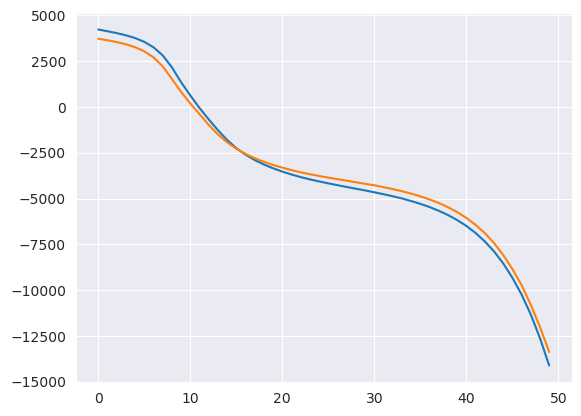

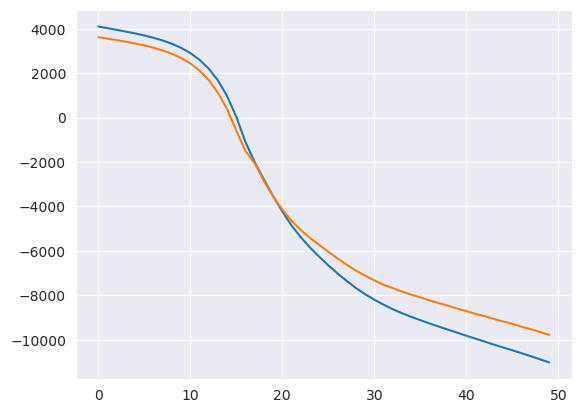

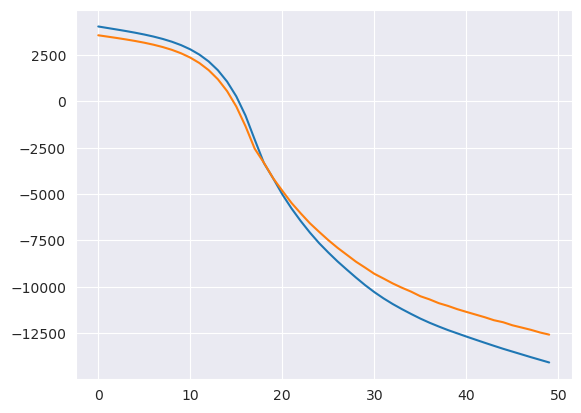

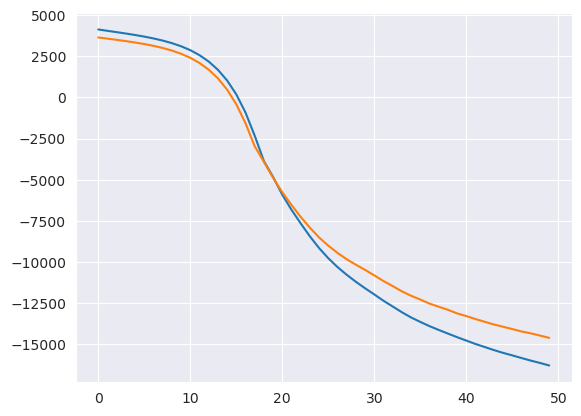

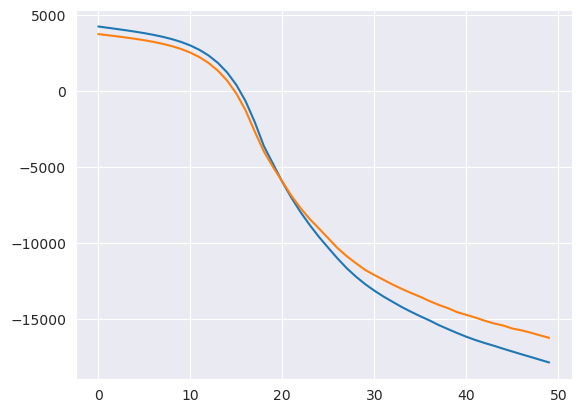

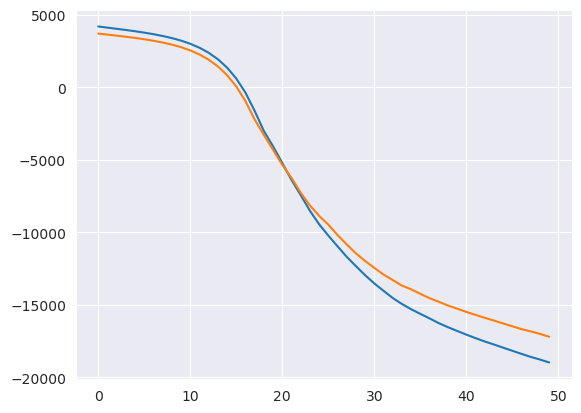

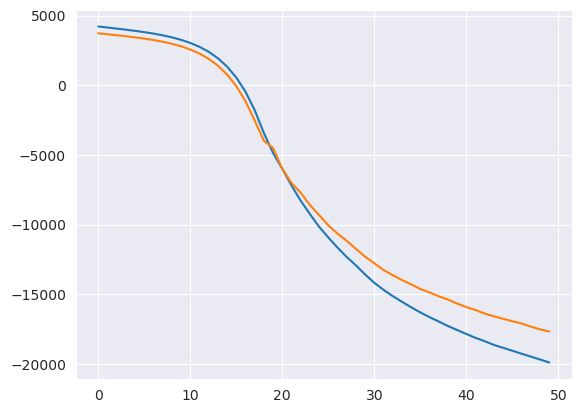

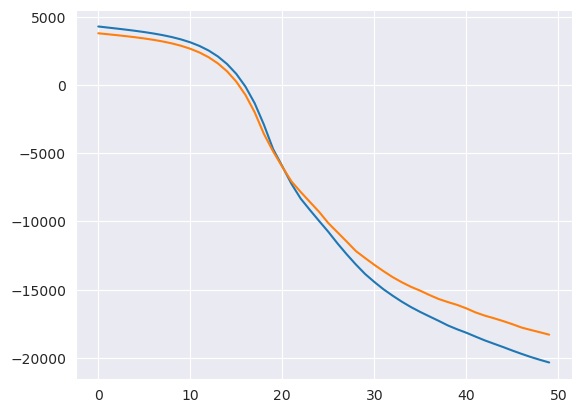

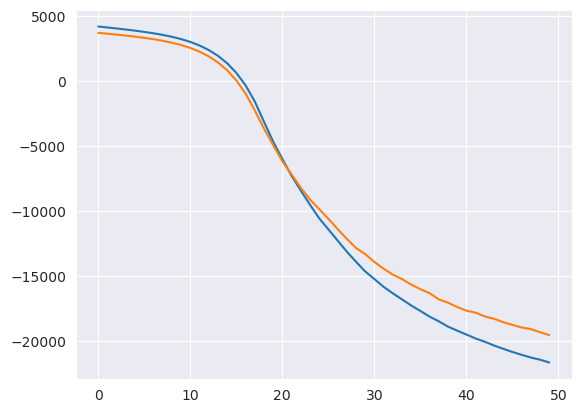

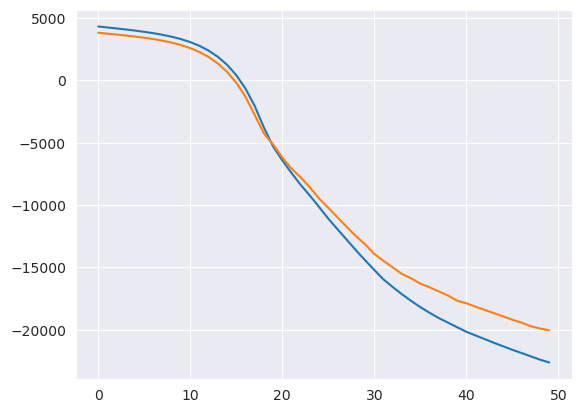

In [18]:
for i in range(10):
    plt.figure(i)  # Create a new figure for each plot
    plt.plot(np.array(loss_vals[i][0]))
    plt.plot(np.array(loss_vals[i][1]))
    plt.show()  # Display the plot

In [19]:
model_path = model_base_path/'hyperparameters.pkl'

with open(model_path, 'wb') as f:
    pickle.dump({'ncomps':ncomps, 'nevecs':nevecs,'nbasecomps':nbasecomps, 'ncauses':ncauses, 'crop_size':crop_size}, f)

## Linear regression

In [20]:
import torch
import yaml
from utils.helpers import dict2namespace

with open(macaw_path/'config'/'ukbb.yaml', 'r') as f:
    config_raw = yaml.load(f, Loader=yaml.FullLoader)
    
config = dict2namespace(config_raw)
config.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [21]:
ed =  encoded_data[:,:nevecs]
X = np.hstack([sex[:,np.newaxis], bmi[:,np.newaxis], ed])    

NameError: name 'sex' is not defined

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, age)

In [ ]:
reg.score(X, age)

In [ ]:
lr_path = model_base_path/'lr.pkl'

with open(lr_path, 'wb') as f:
    pickle.dump({'reg':reg}, f)

In [ ]:
lr_path

In [ ]:
reg.coef_

In [ ]:
np.mean(np.abs(reg.predict(X) - age))

In [ ]:
idx = 0
macaw = torch.load(model_base_path/f'{idx}.pt')
X_test = np.hstack([sex[:,np.newaxis], age[:,np.newaxis], bmi[:,np.newaxis], encoded_data[:,idx:nevecs+idx]])

In [ ]:
encoded_data.shape

In [ ]:
probs=[]
for i in range(36):
    X_test[:,1] = i
    probs.append(macaw.log_likelihood(X_test))

In [ ]:
pexp = np.exp(np.array(probs))
pexp_sum = np.sum(pexp,axis=0)
p = pexp/pexp_sum

In [ ]:
pred_labels = np.argmax(probs, axis=0)

In [ ]:
age_bins=36

In [ ]:
sns.histplot(age, bins=age_bins)
sns.histplot(pred_labels,bins=age_bins)

In [ ]:
l = np.array(probs)[:,80]
plt.bar(np.arange(36),l-np.min(l))

In [ ]:
sns.histplot(age-pred_labels, bins=age_bins)

In [ ]:
np.mean(np.abs(pred_labels - age))